In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image
from tqdm import tqdm
import pandas as pd

torch.manual_seed(42)
np.random.seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


## 1. Define TARNet Architecture

In [2]:
class CNNFeatureExtractor(nn.Module):
    """CNN with 3-4 conv layers for medical image feature extraction"""
    def __init__(self, in_channels=1, output_dim=256):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_channels, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1))
        )
        self.fc = nn.Linear(128, output_dim)
    
    def forward(self, x):
        rep = self.features(x)
        rep = rep.view(rep.size(0), -1)
        return self.fc(rep)

class TARNet(nn.Module):
    """Treatment-Agnostic Representation Network with separate MLP heads"""
    def __init__(self, cnn_feat, rep_dim=256, hidden_dim=200):
        super().__init__()
        self.cnn_feat = cnn_feat
        
        # MLP head for control outcome Y0
        self.head_0 = nn.Sequential(
            nn.Linear(rep_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, 1)
        )
        
        # MLP head for treatment outcome Y1
        self.head_1 = nn.Sequential(
            nn.Linear(rep_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, 1)
        )
    
    def forward(self, x, t=None):
        rep = self.cnn_feat(x)
        y0 = self.head_0(rep).squeeze(-1)
        y1 = self.head_1(rep).squeeze(-1)
        
        if t is None:
            return y0, y1, rep
        else:
            y = torch.where(t == 1, y1, y0)
            return y, y0, y1, rep

## 2. Load Pre-trained Model

In [ ]:
loaded_obj = torch.load('tarnet_arch.pth', map_location=device, weights_only=False)
model = loaded_obj.to(device)
print("Loaded pre-trained model (full model)")

Loaded pre-trained model (full model) from tarnet.pth


## 3. Dataset: Real Images + Synthetic Confounders U

In [24]:
class MedicalImageDataset(Dataset):
    """
    Load real medical images from Data/train or Data/test
    Generate only missing confounders U and treatment assignments
    Use actual disease category to define outcomes
    """
    def __init__(self, data_dir, split='train', image_size=64, 
                 confounder_dim=8, beta_strength=1.0):
        self.data_dir = Path(data_dir) / split
        self.image_size = image_size
        self.confounder_dim = confounder_dim
        self.beta_strength = beta_strength
        
        self.image_paths = []
        self.categories = []
        
        for category in ['NORMAL', 'PNEUMONIA', 'COVID19']:
            category_path = self.data_dir / category
            if category_path.exists():
                for img_path in sorted(category_path.glob('*.jpg')):
                    self.image_paths.append(img_path)
                    self.categories.append(category)
        
        print(f"\nLoaded {len(self.image_paths)} images from {split} split")
        category_counts = pd.Series(self.categories).value_counts()
        print(f"Categories: {category_counts.to_dict()}")
        
        self._generate_confounders_and_treatment()
    
    def _load_image(self, img_path):
        """Load and preprocess a single image"""
        img = Image.open(img_path).convert('L')  # Grayscale
        img = img.resize((self.image_size, self.image_size))
        img = np.array(img, dtype=np.float32) / 255.0
        img = (img - 0.5) / 0.5  # Normalize to [-1, 1]
        return torch.FloatTensor(img).unsqueeze(0)
    
    def _generate_confounders_and_treatment(self):
        """
        Generate missing confounders U and treatment assignments.
        U represents unmeasured patient characteristics (comorbidities, genetics, etc.)
        Treatment assignment depends on both observed images and unobserved U.
        """
        n = len(self.image_paths)
        
        Z2 = np.random.randn(n, self.confounder_dim)
        
        self.U = Z2 + np.random.randn(n, self.confounder_dim) * 0.1
        
        # Map disease categories to severity scores (for treatment propensity)?????
        severity_map = {'NORMAL': 0.0, 'PNEUMONIA': 0.5, 'COVID19': 1.0}
        severity = np.array([severity_map[cat] for cat in self.categories])
        
        print("Generate treatment assignments:")
        # Treatment propensity based on:
        # - Disease severity (observable from images)
        # - Confounders U (unobservable patient characteristics)
        alpha = 2.0  # Weight for disease severity
        beta = np.random.randn(self.confounder_dim)
        beta = beta / np.linalg.norm(beta) * self.beta_strength
        
        logits = alpha * severity + self.U @ beta
        propensity = 1 / (1 + np.exp(-logits))
        self.T = (np.random.rand(n) < propensity).astype(np.int64)
        
        print(f"Treatment rate: {self.T.mean():.3f}")
        print(f"Treatment by category:")
        for cat in ['NORMAL', 'PNEUMONIA', 'COVID19']:
            mask = np.array(self.categories) == cat
            if mask.sum() > 0:
                print(f"  {cat}: {self.T[mask].mean():.3f}")
        
        base_outcome = severity * 5.0 + self.U[:, 0] * 1.0 + np.random.randn(n) * 0.5
        
        # Treatment effect: more effective for severe cases
        treatment_effect = -(2.0 + severity * 3.0 + self.U[:, 1] * 0.5)
        
        # Potential outcomes
        self.Y0 = base_outcome + np.random.randn(n) * 0.3  # Without treatment
        self.Y1 = base_outcome + treatment_effect + np.random.randn(n) * 0.3  # With treatment
        
        # Observed outcome (factual)
        self.Y = self.T * self.Y1 + (1 - self.T) * self.Y0
        
        # True individual treatment effect
        self.true_ITE = self.Y1 - self.Y0
        
        print(f"Outcome statistics:")
        print(f"  Y0 (control): mean={self.Y0.mean():.3f}, std={self.Y0.std():.3f}")
        print(f"  Y1 (treated): mean={self.Y1.mean():.3f}, std={self.Y1.std():.3f}")
        print(f"  True ATE: {self.true_ITE.mean():.3f}")
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img = self._load_image(self.image_paths[idx])
        return {
            'image': img,
            'treatment': torch.LongTensor([self.T[idx]])[0],
            'outcome': torch.FloatTensor([self.Y[idx]])[0],
            'y0': torch.FloatTensor([self.Y0[idx]])[0],
            'y1': torch.FloatTensor([self.Y1[idx]])[0],
            'ite': torch.FloatTensor([self.true_ITE[idx]])[0],
            'category': self.categories[idx]
        }

## 4. Load Real Medical Images

In [25]:
data_dir = 'Data'

image_size = 64
confounder_dim = 8  # Dimension of unobserved confounders U
beta_strength = 1.0  # Strength of confounding (higher = more bias)

train_dataset = MedicalImageDataset(
    data_dir=data_dir,
    split='train',
    image_size=image_size,
    confounder_dim=confounder_dim,
    beta_strength=beta_strength
)

test_dataset = MedicalImageDataset(
    data_dir=data_dir,
    split='test',
    image_size=image_size,
    confounder_dim=confounder_dim,
    beta_strength=beta_strength
)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"\nDataLoaders created with batch_size={batch_size}")


Loaded 5144 images from train split
Categories: {'PNEUMONIA': 3418, 'NORMAL': 1266, 'COVID19': 460}
Generate treatment assignments:
Treatment rate: 0.659
Treatment by category:
  NORMAL: 0.508
  PNEUMONIA: 0.692
  COVID19: 0.828
Outcome statistics:
  Y0 (control): mean=2.099, std=1.836
  Y1 (treated): mean=-1.178, std=1.409
  True ATE: -3.277

Loaded 1288 images from test split
Categories: {'PNEUMONIA': 855, 'NORMAL': 317, 'COVID19': 116}
Generate treatment assignments:
Treatment rate: 0.667
Treatment by category:
  NORMAL: 0.464
  PNEUMONIA: 0.717
  COVID19: 0.853
Outcome statistics:
  Y0 (control): mean=2.050, std=1.782
  Y1 (treated): mean=-1.229, std=1.354
  True ATE: -3.278

DataLoaders created with batch_size=32


## 5. Tuning TARNet


Training TARNet...
Epoch 5/30, Loss: 2.0323
Epoch 10/30, Loss: 1.9849
Epoch 15/30, Loss: 1.9410
Epoch 20/30, Loss: 1.9144
Epoch 25/30, Loss: 1.9012
Epoch 30/30, Loss: 1.8304

✓ Model saved to tarnet_medical_images.pth


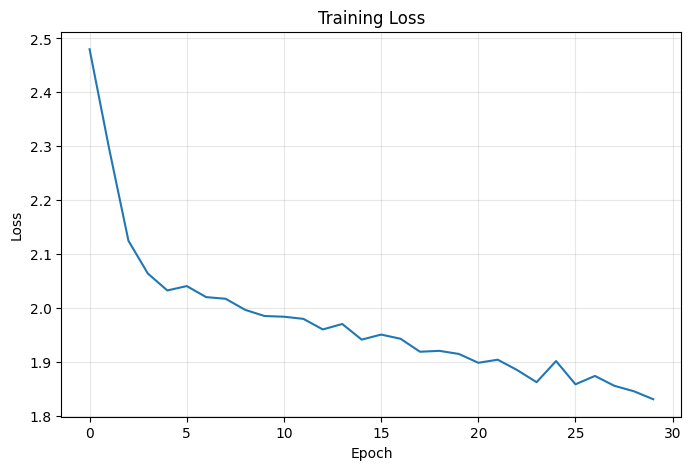

In [ ]:
def train_model(model, train_loader, num_epochs=30, lr=0.001):
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
    criterion = nn.MSELoss()
    
    train_losses = []
    model.train()
    
    for epoch in range(num_epochs):
        total_loss = 0
        for batch in train_loader:
            images = batch['image'].to(device)
            treatments = batch['treatment'].to(device).float()
            outcomes = batch['outcome'].to(device)
            
            optimizer.zero_grad()
            y_pred, _, _, _ = model(images, treatments)
            loss = criterion(y_pred, outcomes)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
        
        avg_loss = total_loss / len(train_loader)
        train_losses.append(avg_loss)
        
        if (epoch + 1) % 5 == 0:
            print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}")
    
    return train_losses

print("\nTraining TARNet:")
train_losses = train_model(model, train_loader, num_epochs=30, lr=0.001)

torch.save(model.state_dict(), 'tarnet_medical_images.pth')
print("\nModel saved to tarnet_medical_images.pth")

plt.figure(figsize=(8, 5))
plt.plot(train_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.grid(True, alpha=0.3)
plt.savefig('training_loss.png', dpi=150, bbox_inches='tight')
plt.show()

## 7. Evaluate Model

In [8]:
def evaluate_model(model, data_loader):
    """Evaluate TARNet and compute PEHE and ATE errors"""
    model.eval()
    
    all_y0_pred = []
    all_y1_pred = []
    all_y0_true = []
    all_y1_true = []
    all_ite_true = []
    
    with torch.no_grad():
        for batch in data_loader:
            images = batch['image'].to(device)
            y0_pred, y1_pred, _ = model(images, t=None)
            
            all_y0_pred.append(y0_pred.cpu().numpy())
            all_y1_pred.append(y1_pred.cpu().numpy())
            all_y0_true.append(batch['y0'].numpy())
            all_y1_true.append(batch['y1'].numpy())
            all_ite_true.append(batch['ite'].numpy())
    
    y0_pred = np.concatenate(all_y0_pred)
    y1_pred = np.concatenate(all_y1_pred)
    y0_true = np.concatenate(all_y0_true)
    y1_true = np.concatenate(all_y1_true)
    ite_true = np.concatenate(all_ite_true)
    
    ite_pred = y1_pred - y0_pred
    
    # Calculate metrics
    pehe = np.sqrt(np.mean((ite_pred - ite_true) ** 2))
    ate_true = ite_true.mean()
    ate_pred = ite_pred.mean()
    ate_error = np.abs(ate_true - ate_pred)
    
    print(f"\n{'='*50}")
    print("EVALUATION RESULTS")
    print(f"{'='*50}")
    print(f"√PEHE (lower is better):    {pehe:.4f}")
    print(f"True ATE:                   {ate_true:.4f}")
    print(f"Predicted ATE:              {ate_pred:.4f}")
    print(f"ATE Error:                  {ate_error:.4f}")
    print(f"{'='*50}\n")
    
    return ite_pred, ite_true, y0_pred, y1_pred, y0_true, y1_true

# Evaluate on test set
ite_pred, ite_true, y0_pred, y1_pred, y0_true, y1_true = evaluate_model(model, test_loader)


EVALUATION RESULTS
√PEHE (lower is better):    0.9161
True ATE:                   -3.2658
Predicted ATE:              -3.0253
ATE Error:                  0.2406

